# Agricultural-crops-image-classification
- ### Azure Custom Vision - Image Classification Project

##### Importing utility functions and Python modules

In [1]:
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import os, time, uuid

In [2]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials


### Resources:
- Azure Custom Vision Endpoint
- Training Reource ID and Key
- Prediction Resource ID and Key

## Make sure you have the correct Training and Prediction Endpoints, Keys and Resource IDs separately

In [3]:
TRAINING_ENDPOINT= "---------------------------------------------"
training_key = "---------------------------------------------"
training_resource_id = "---------------------------------------------"

In [4]:
PREDICTION_ENDPOINT = "---------------------------------------------"
prediction_key = "---------------------------------------------"
prediction_resource_id = "---------------------------------------------"

##### Instantiate and authenticate the training client with endpoint and key 

In [5]:
training_credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(TRAINING_ENDPOINT, training_credentials)

In [6]:
trainer.api_version

'3.4-preview'

##### Creating Training Project First

In [7]:
# Create a new project
print ("Training project created. Proceed to the next cell.")
project_name = uuid.uuid4()
project = trainer.create_project(project_name)

Training project created. Proceed to the next cell.


##### Getting Project Details as collective information 

In [8]:
project.as_dict()

{'id': '1ec2987a-256a-40d6-afea-ca50fc0ba906',
 'name': '91c4799d-9367-4a91-8d2b-d852e56f99af',
 'description': '',
 'settings': {'domain_id': 'ee85a74c-405e-4adc-bb47-ffa8ca0c9f31',
  'classification_type': 'Multilabel',
  'target_export_platforms': [],
  'use_negative_set': True,
  'image_processing_settings': {'augmentation_methods': {'rotation': True,
    'scaling': True,
    'translation': True,
    'horizontal flip': True,
    'equalize': True,
    'solarize': True,
    'padtosquare': True}}},
 'created': '2023-09-04T20:30:27.233Z',
 'last_modified': '2023-09-04T20:30:27.233Z',
 'dr_mode_enabled': False,
 'status': 'Succeeded'}

##### Adding Tags based on training requirements
- We have 15 tags in the training process 
  - cotton
  - lemon
  - sunflower
  - ...

In [9]:
cotton_tag = trainer.create_tag(project.id, "cotton")

In [10]:
lemon_tag = trainer.create_tag(project.id, "lemon")

In [11]:
sunflower_tag = trainer.create_tag(project.id, "sunflower")

##### Upload Traning Data 

##### Enter local file system location of the traning images 
- All training images are saved in subfolders of the main folder`Agricultural-crops`. 
- You can view these image folders:
    - You will find all wheat images in the `wheat` folder
    - You will find all cucumber images in the `cucumber` folder
    - You will find all the tomato images in the `tomato` folder
    - There are also some test images for you to perform predictions later.

In [12]:
# Get current working directory
# The output will give you the "local_image_path" used in the cell below
#!pwd

In [13]:
local_image_path = os.path.join(os.getcwd(), 'Agricultural-crops')
local_image_path

'/home/mohamed-ghazal/git/AI Engineer using Microsoft Azure/Building Computer Vision Solutions with Azure/Image Classification/Agricultural-crops'

In [14]:
# Some code is taken from Azure SDK Sample and added my own code here
def upload_images_for_training(local_project_id, local_img_folder_name, image_tag_id):
    image_list = []
    files = os.listdir(os.path.join (local_image_path, local_img_folder_name))
    for file in files:
        full_path = os.path.join(local_image_path, local_img_folder_name, file)
        if os.path.isfile(full_path) and full_path.endswith('.jpg'):
            with open(os.path.join (local_image_path, local_img_folder_name, file), "rb") as image_contents:
                image_list.append(ImageFileCreateEntry(name=file, contents=image_contents.read(), tag_ids=[image_tag_id]))
                
    upload_result = trainer.create_images_from_files(local_project_id, ImageFileCreateBatch(images=image_list))
    if not upload_result.is_batch_successful:
        print("Image batch upload failed.")
        for image in upload_result.images:
            print("Image status: ", image.status)
        exit(-1)
    return upload_result

In [15]:
cotton_upload_result = upload_images_for_training(project.id, 'cotton', cotton_tag.id)

In [16]:
cotton_upload_result.is_batch_successful

True

In [17]:
lemon_upload_result = upload_images_for_training(project.id, 'lemon', lemon_tag.id)

In [18]:
lemon_upload_result.is_batch_successful

True

In [19]:
sunflower_upload_result = upload_images_for_training(project.id, 'sunflower', sunflower_tag.id)

In [20]:
sunflower_upload_result.is_batch_successful

True

##### Start the Image Classification Training
- We will keep checking the training progress every 10 seconds

In [21]:
iteration = trainer.train_project(project.id)
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    print ("Waiting 10 seconds...")
    time.sleep(10)

Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Completed
Waiting 10 seconds...


##### After training is complete, let's look at the Model Performance

In [22]:
iteration.as_dict()

{'id': '1795a7be-a0da-4dc6-bc57-ef27b91eade3',
 'name': 'Iteration 1',
 'status': 'Completed',
 'created': '2023-09-04T20:30:28.283Z',
 'last_modified': '2023-09-04T20:35:18.469Z',
 'trained_at': '2023-09-04T20:35:18.462Z',
 'project_id': '1ec2987a-256a-40d6-afea-ca50fc0ba906',
 'exportable': False,
 'domain_id': 'ee85a74c-405e-4adc-bb47-ffa8ca0c9f31',
 'classification_type': 'Multilabel',
 'training_type': 'Regular',
 'reserved_budget_in_hours': 0,
 'training_time_in_minutes': 1}

In [23]:
iteration_list = trainer.get_iterations(project.id)
for iteration_item in iteration_list:
    print(iteration_item)

{'additional_properties': {}, 'id': '1795a7be-a0da-4dc6-bc57-ef27b91eade3', 'name': 'Iteration 1', 'status': 'Completed', 'created': datetime.datetime(2023, 9, 4, 20, 30, 28, 283000, tzinfo=<isodate.tzinfo.Utc object at 0x7f5eaa7f5730>), 'last_modified': datetime.datetime(2023, 9, 4, 20, 35, 18, 469000, tzinfo=<isodate.tzinfo.Utc object at 0x7f5eaa7f5730>), 'trained_at': datetime.datetime(2023, 9, 4, 20, 35, 18, 462000, tzinfo=<isodate.tzinfo.Utc object at 0x7f5eaa7f5730>), 'project_id': '1ec2987a-256a-40d6-afea-ca50fc0ba906', 'exportable': False, 'exportable_to': None, 'domain_id': 'ee85a74c-405e-4adc-bb47-ffa8ca0c9f31', 'classification_type': 'Multilabel', 'training_type': 'Regular', 'reserved_budget_in_hours': 0, 'training_time_in_minutes': 1, 'publish_name': None, 'original_publish_resource_id': None, 'custom_base_model_info': None, 'training_error_details': None}


In [24]:
model_perf = trainer.get_iteration_performance(project.id, iteration_list[0].id)

In [25]:
model_perf.as_dict()

{'per_tag_performance': [{'id': '69a2ff5e-6e0a-487d-a003-e250ee27dbf3',
   'name': 'cotton',
   'precision': 0.0,
   'precision_std_deviation': 0.0,
   'recall': 0.0,
   'recall_std_deviation': 0.0,
   'average_precision': 1.0},
  {'id': 'd121df32-01f8-4fae-8c3f-dd22a0a53cca',
   'name': 'lemon',
   'precision': 0.0,
   'precision_std_deviation': 0.0,
   'recall': 0.0,
   'recall_std_deviation': 0.0,
   'average_precision': 1.0},
  {'id': '0e2540e8-9604-4198-ba3a-60922d69658e',
   'name': 'sunflower',
   'precision': 0.0,
   'precision_std_deviation': 0.0,
   'recall': 0.0,
   'recall_std_deviation': 0.0,
   'average_precision': 1.0}],
 'precision': 0.0,
 'precision_std_deviation': 0.0,
 'recall': 0.0,
 'recall_std_deviation': 0.0,
 'average_precision': 1.0}

##### Publishing the Model to the Project Endpoint

In [26]:
# Setting the Iteration Name, this will be used when Model training is completed
# Please choose a name favorable to you.
publish_iteration_name = "agricultural-crops-img-classification-iteration1"

In [27]:
# The iteration is now trained. Publish it to the project endpoint
trainer.publish_iteration(project.id, iteration.id, publish_iteration_name, prediction_resource_id)
print ("Done!")

Done!


##### Instantiate and authenticate the prediction client with endpoint and key

In [28]:
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(PREDICTION_ENDPOINT, prediction_credentials)

In [29]:
predictor.api_version

'3.1'

##### Performing Prediction
- Using the predictor object 

In [30]:
def perform_prediction(image_file_name):
    with open(os.path.join (local_image_path,  image_file_name), "rb") as image_contents:
        results = predictor.classify_image(project.id, publish_iteration_name, image_contents.read())
        # Display the results.
        for prediction in results.predictions:
            print("\t" + prediction.tag_name +
                  ": {0:.2f}%".format(prediction.probability * 100))

##### The test images are stored in the local file system of this workspace
* You will perform prediction(s)

In [31]:
# To list the folders/files in your current working directory
# The name of any image file can be used as "file_name" in the cell below
!ls
os.listdir('Agricultural-crops')

Agricultural-crops  L5Demo1-PredictAPId-1.ipynb
image-test-1.jpg    L5Demo2-ImageClassification.ipynb
image-test-2.jpg


['image-test-9.jpg',
 'lemon',
 'image-test-1.jpg',
 'image-test-3.jpeg',
 'image-test-5.jpg',
 'chilli',
 'image-test-7.jpg',
 'cardamom',
 'image-test-8.jpg',
 'maize',
 'rice',
 'image-test-2.jpg',
 'sunflower',
 'image-test-3.jpg',
 'image-test-4.jpeg',
 'Cherry',
 'cotton']

In [32]:
file_name = 'image-test-1.jpg'

In [33]:
# Pick one test image file name from the output of the previous cell
# Use the same image file name for this cell and the next one
perform_prediction(file_name)

	cotton: 45.83%
	sunflower: 35.65%
	lemon: 30.36%


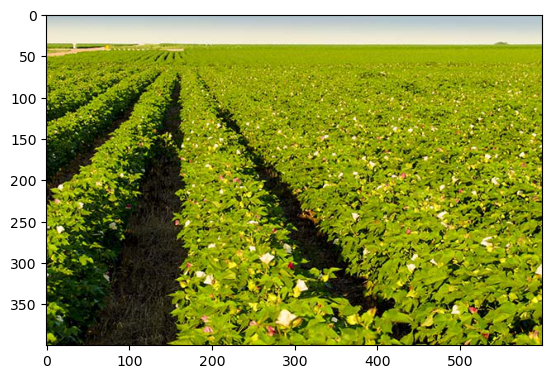

In [34]:
# Checking the image
with open(os.path.join (local_image_path, file_name), 'rb') as img_code:
    img_view_ready = Image.open(img_code)
    plt.figure()
    plt.imshow(img_view_ready)

In [35]:
file_name_2 = 'image-test-7.jpg'

In [36]:
# Perform prediction again using another image
perform_prediction(file_name_2)

	sunflower: 54.02%
	cotton: 27.62%
	lemon: 24.51%


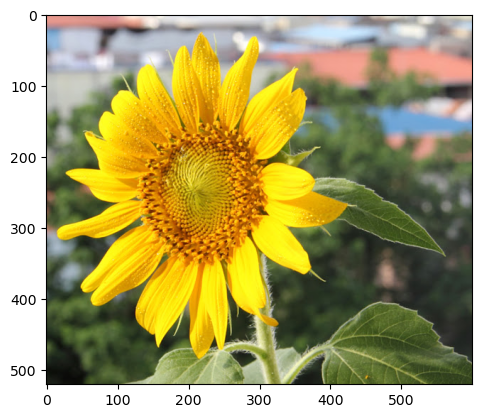

In [37]:
# Checking the second image
with open(os.path.join (local_image_path, file_name_2), 'rb') as img_code:
    img_view_ready = Image.open(img_code)
    plt.figure()
    plt.imshow(img_view_ready)

In [38]:
file_name_3 = 'image-test-5.jpg'

In [39]:
# Perform prediction again using another image
perform_prediction(file_name_3)

	lemon: 55.94%
	cotton: 26.02%
	sunflower: 21.30%


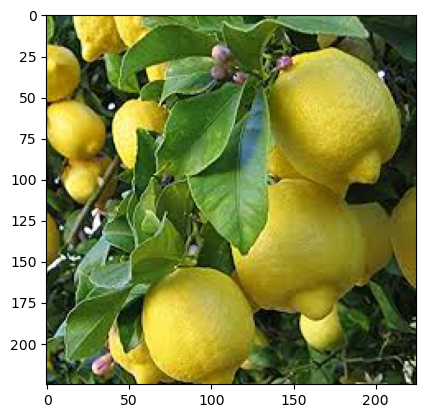

In [40]:
# Checking the second image
with open(os.path.join (local_image_path, file_name_3), 'rb') as img_code:
    img_view_ready = Image.open(img_code)
    plt.figure()
    plt.imshow(img_view_ready)